In [ ]:
!pip install pydub
!pip install librosa

In [ ]:
import os
import pathlib
import tensorflow as tf
from pydub import AudioSegment
from tensorflow.keras.layers.experimental import preprocessing
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras import layers
import pydub
import librosa
import librosa.display
import glob
import random
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sib_path=glob.glob('/content/drive/MyDrive/DATA/sib/*')
port_path=glob.glob('/content/drive/MyDrive/DATA/porteghal/*')
golabi_path=glob.glob('/content/drive/MyDrive/DATA/golabi/*')
len(sib_path)

58

In [ ]:
for i in range(len(sib_path)):
  sound = AudioSegment.from_mp3(sib_path[i])
  sound = sound.set_channels(1)
  sound.export("/content/drive/MyDrive/data_converted/sib/s"+str(i+1)+".wav", format="wav")
  sound.export()

In [ ]:
for i in range(len(port_path)):
  sound = AudioSegment.from_mp3(port_path[i])
  sound = sound.set_channels(1)
  sound.export("/content/drive/MyDrive/data_converted/porteqal/p"+str(i+1)+".wav", format="wav")
  sound.export()

In [ ]:
for i in range(len(golabi_path)):
  sound = AudioSegment.from_mp3(golabi_path[i])
  sound = sound.set_channels(1)
  sound.export("/content/drive/MyDrive/data_converted/golabi/g"+str(i+1)+".wav", format="wav")
  sound.export()

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/data_converted')
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('fruits:', commands)

fruits: ['sib' 'porteqal' 'golabi']


In [ ]:
train_files = filenames[:150]
val_files = filenames[150: 150 + 24]
print('Training set size', len(train_files))
print('Validation set size', len(val_files))

Training set size 150
Validation set size 24


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-2] 

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
def get_spectrogram(waveform):
  zero_padding = tf.zeros([200000])
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  AUTOTUNE = tf.data.AUTOTUNE
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
spectrogram_ds = train_ds

In [ ]:
batch_size = 1
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.batch(batch_size)
val_ds   = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  inputshape = spectrogram.shape
num_labels = len(commands)


MLP Model

In [ ]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

MLP = Sequential([
    layers.Input(shape=inputshape),
    preprocessing.Resizing(40, 40), 
    norm_layer,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_labels, activation='softmax'),
])

MLP.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_2 (Resizing)        (None, 40, 40, 1)         0         
_________________________________________________________________
normalization_2 (Normalizati (None, 40, 40, 1)         3         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               204928    
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)               

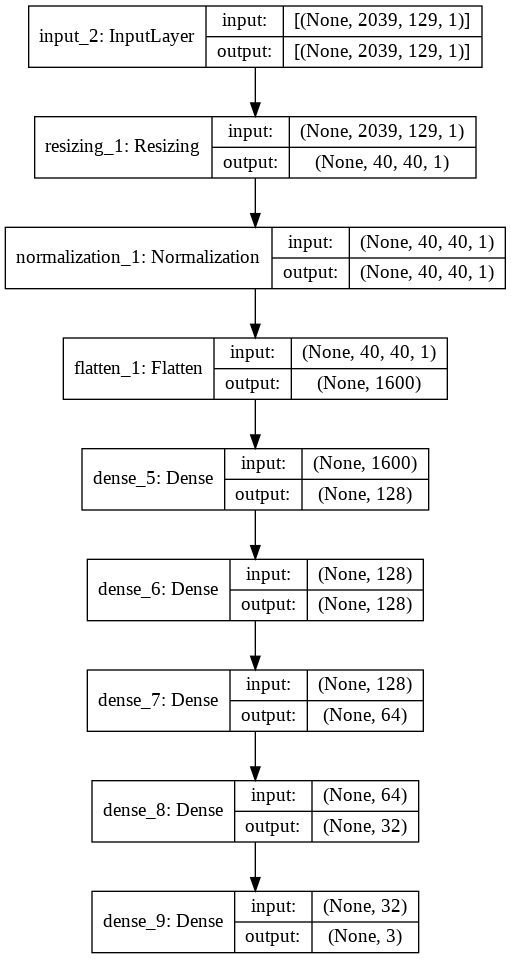

In [ ]:
keras.utils.plot_model(MLP, "MLP.png", show_shapes= True)

In [ ]:
MLP.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 50
MLP_history = MLP.fit(
    train_ds,  
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/50
150/150 [==============================] - 7s 44ms/step - loss: 0.8522 - accuracy: 0.7867 - val_loss: 0.3057 - val_accuracy: 0.8750
Epoch 2/50
150/150 [==============================] - 0s 3ms/step - loss: 0.3180 - accuracy: 0.8733 - val_loss: 0.1447 - val_accuracy: 0.9583
Epoch 3/50
150/150 [==============================] - 0s 3ms/step - loss: 0.1627 - accuracy: 0.9600 - val_loss: 0.1820 - val_accuracy: 0.9167
Epoch 4/50
150/150 [==============================] - 0s 3ms/step - loss: 0.0687 - accuracy: 0.9733 - val_loss: 0.1270 - val_accuracy: 0.9583
Epoch 5/50
150/150 [==============================] - 0s 3ms/step - loss: 0.0711 - accuracy: 0.9800 - val_loss: 0.2259 - val_accuracy: 0.9583
Epoch 6/50
150/150 [==============================] - 0s 3ms/step - loss: 0.1209 - accuracy: 0.9600 - val_loss: 0.2749 - val_accuracy: 0.9583
Epoch 7/50
150/150 [==============================] - 0s 3ms/step - loss: 0.2644 - accuracy: 0.9133 - val_loss: 0.1384 - val_accuracy: 0.9583
Epoch

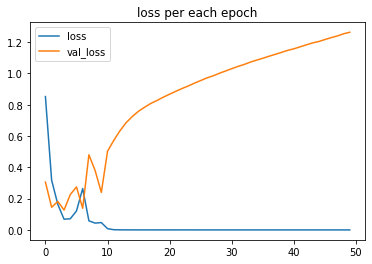

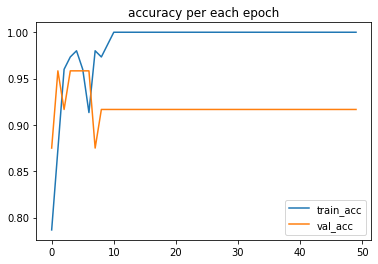

In [ ]:
metrics = MLP_history.history
plt.plot(MLP_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss per each epoch')
plt.show()

plt.plot(MLP_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.title('accuracy per each epoch')
plt.legend(['train_acc','val_acc'])
plt.show()

In [ ]:
train_audio = []
train_labels = []

train_dss = preprocess_dataset(train_files)
for audio, label in train_dss:
  train_audio.append(audio.numpy())
  train_labels.append(label.numpy())

train_audio = np.array(train_audio)
train_labels = np.array(train_labels)

y_pred = np.argmax(MLP.predict(train_ds), axis=1)
y_true = train_labels

train_acc = sum(y_pred == y_true) / len(y_true)
print(f'Train accuracy: {train_acc:.0%}')

Train accuracy: 100%


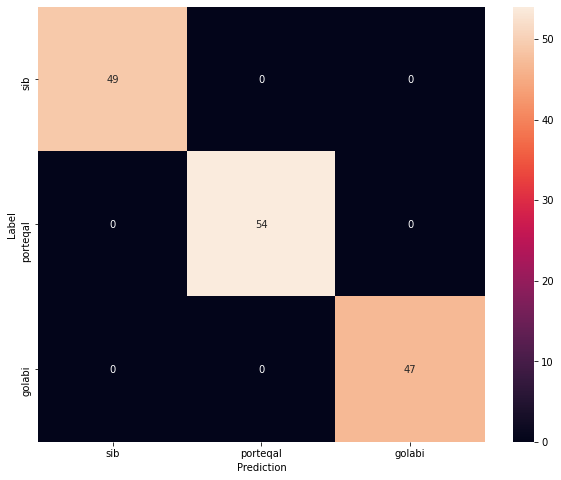

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
val_audio = []
val_labels = []

val_dss = preprocess_dataset(val_files)
for audio, label in val_dss:
  val_audio.append(audio.numpy())
  val_labels.append(label.numpy())

val_audio = np.array(val_audio)
val_labels = np.array(val_labels)

y_predv = np.argmax(MLP.predict(val_ds), axis=1)
y_truev = val_labels

val_acc = sum(y_predv == y_truev) / len(y_truev)
print(f'Val accuracy: {val_acc:.0%}')

Val accuracy: 92%


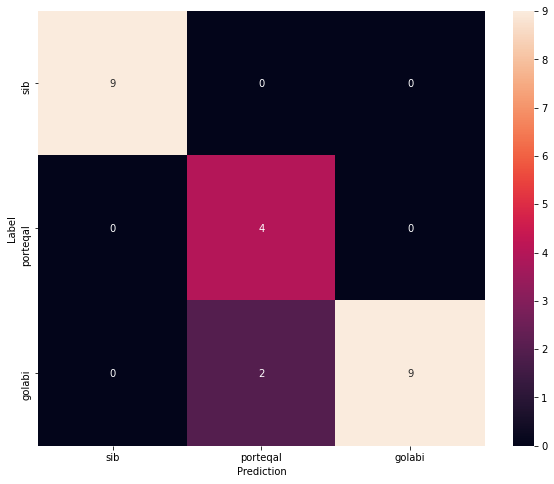

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_truev, y_predv) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
target_names=['Apple', 'Orange', 'Pear']
print(classification_report(y_truev, y_predv, target_names=target_names))

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00         9
      Orange       0.67      1.00      0.80         4
        Pear       1.00      0.82      0.90        11

    accuracy                           0.92        24
   macro avg       0.89      0.94      0.90        24
weighted avg       0.94      0.92      0.92        24



CNN Model

In [ ]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

CNN = Sequential([
    layers.Input(shape=inputshape),
    preprocessing.Resizing(40, 40), 
    norm_layer,
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(46, 3, activation='relu'),
    layers.Dropout(0.1),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels, activation='softmax'),
])

CNN.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_5 (Resizing)        (None, 40, 40, 1)         0         
_________________________________________________________________
normalization_5 (Normalizati (None, 40, 40, 1)         3         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 38, 64)        640       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 36, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 46)        13294     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 46)       

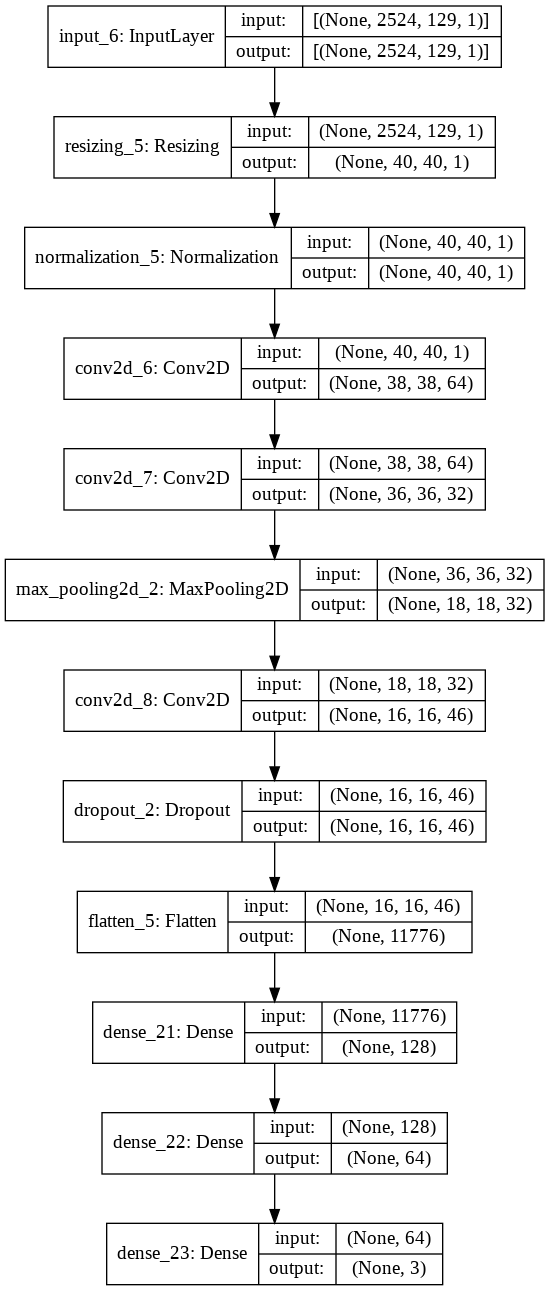

In [ ]:
keras.utils.plot_model(CNN, "CNN.png", show_shapes= True)

In [ ]:
CNN.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 50
CNN_history = CNN.fit(
    train_ds,  
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/50
150/150 [==============================] - 9s 58ms/step - loss: 1.3856 - accuracy: 0.7600 - val_loss: 0.5319 - val_accuracy: 0.8750
Epoch 2/50
150/150 [==============================] - 3s 18ms/step - loss: 0.7151 - accuracy: 0.8267 - val_loss: 0.5344 - val_accuracy: 0.7500
Epoch 3/50
150/150 [==============================] - 3s 18ms/step - loss: 0.2517 - accuracy: 0.9133 - val_loss: 0.5449 - val_accuracy: 0.8333
Epoch 4/50
150/150 [==============================] - 3s 19ms/step - loss: 0.2670 - accuracy: 0.8733 - val_loss: 0.9564 - val_accuracy: 0.7500
Epoch 5/50
150/150 [==============================] - 3s 18ms/step - loss: 0.1256 - accuracy: 0.9400 - val_loss: 0.4906 - val_accuracy: 0.9167
Epoch 6/50
150/150 [==============================] - 3s 18ms/step - loss: 0.0476 - accuracy: 0.9933 - val_loss: 0.7621 - val_accuracy: 0.9167
Epoch 7/50
150/150 [==============================] - 3s 18ms/step - loss: 0.0778 - accuracy: 0.9733 - val_loss: 0.9612 - val_accuracy: 0.9167

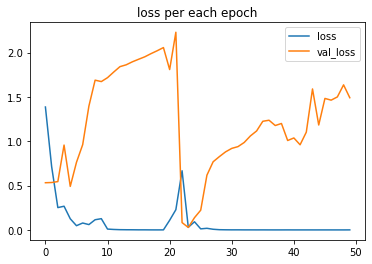

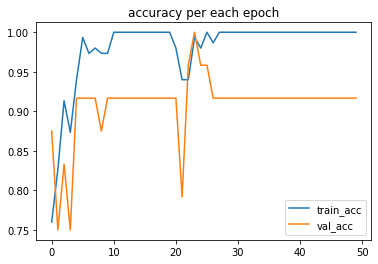

In [ ]:
metrics = CNN_history.history
plt.plot(CNN_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss per each epoch')
plt.show()

plt.plot(CNN_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.title('accuracy per each epoch')
plt.legend(['train_acc','val_acc'])
plt.show()

In [ ]:
train_audio = []
train_labels = []

train_dss = preprocess_dataset(train_files)
for audio, label in train_dss:
  train_audio.append(audio.numpy())
  train_labels.append(label.numpy())

train_audio = np.array(train_audio)
train_labels = np.array(train_labels)

y_pred = np.argmax(CNN.predict(train_ds), axis=1)
y_true = train_labels

train_acc = sum(y_pred == y_true) / len(y_true)
print(f'Train accuracy: {train_acc:.0%}')

Train accuracy: 100%


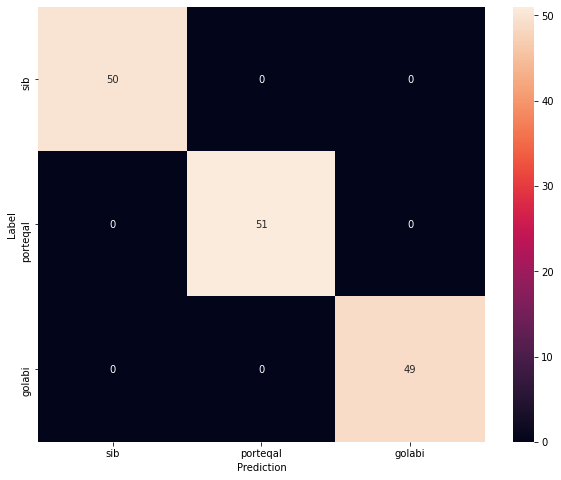

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
val_audio = []
val_labels = []

val_dss = preprocess_dataset(val_files)
for audio, label in val_dss:
  val_audio.append(audio.numpy())
  val_labels.append(label.numpy())

val_audio = np.array(val_audio)
val_labels = np.array(val_labels)

y_predv = np.argmax(CNN.predict(val_ds), axis=1)
y_truev = val_labels

val_acc = sum(y_predv == y_truev) / len(y_truev)
print(f'Val accuracy: {val_acc:.0%}')

Val accuracy: 92%


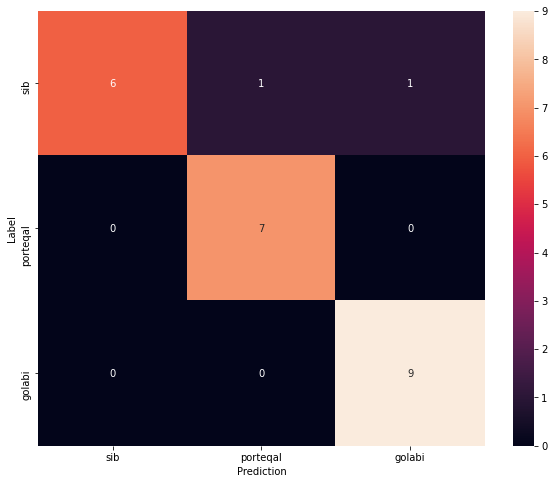

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_truev, y_predv) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
target_names=['Apple', 'Orange', 'Pear']
print(classification_report(y_truev, y_predv, target_names=target_names))

              precision    recall  f1-score   support

       Apple       1.00      0.75      0.86         8
      Orange       0.88      1.00      0.93         7
        Pear       0.90      1.00      0.95         9

    accuracy                           0.92        24
   macro avg       0.92      0.92      0.91        24
weighted avg       0.93      0.92      0.91        24



LSTM Model

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  spectrogram = tf.squeeze(spectrogram)
  inputshape = spectrogram.shape

In [ ]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

LSTM = Sequential([
    layers.Input(shape=inputshape),
    preprocessing.Resizing(40, 40),
    layers.Flatten(),
    norm_layer,
    layers.LSTM(100, return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(100),
    layers.Dense(40, activation='relu'),
    layers.Dense(20, activation='relu'),
    layers.Dense(num_labels, activation='softmax'),
])

LSTM.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_6 (Resizing)        (40, 40, 129)             0         
_________________________________________________________________
flatten_6 (Flatten)          (40, 5160)                0         
_________________________________________________________________
normalization_6 (Normalizati (1, 40, 5160)             3         
_________________________________________________________________
lstm (LSTM)                  (1, 40, 100)              2104400   
_________________________________________________________________
dropout_3 (Dropout)          (1, 40, 100)              0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 100)                  80400     
_________________________________________________________________
dense_24 (Dense)             (1, 40)                  

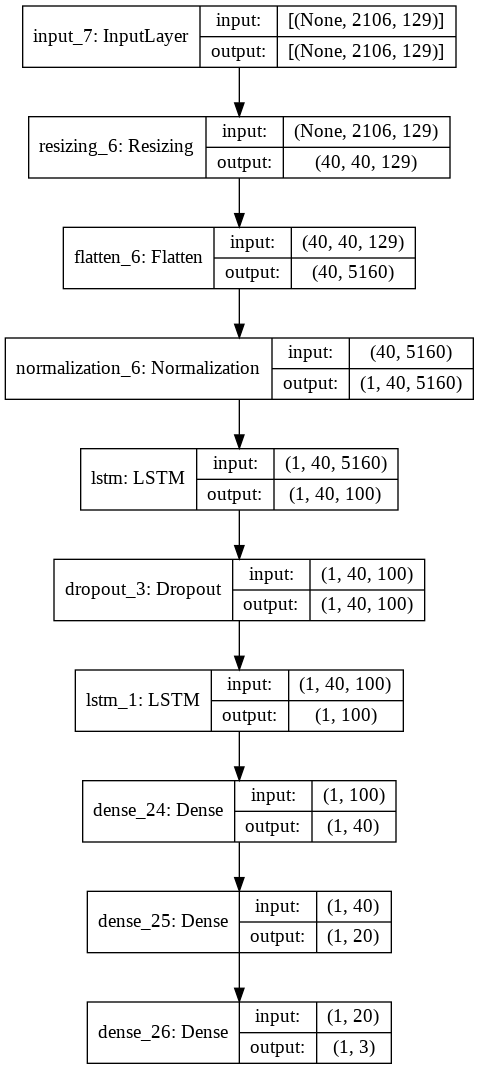

In [ ]:
keras.utils.plot_model(LSTM, "LSTM.png", show_shapes= True)

In [ ]:
LSTM.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 30
LSTM_history = LSTM.fit(
    train_ds,  
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=32,
)

Epoch 1/30
150/150 [==============================] - 30s 180ms/step - loss: 1.1461 - accuracy: 0.3138 - val_loss: 1.1970 - val_accuracy: 0.5417
Epoch 2/30
150/150 [==============================] - 26s 176ms/step - loss: 1.0246 - accuracy: 0.4461 - val_loss: 1.0309 - val_accuracy: 0.4167
Epoch 3/30
150/150 [==============================] - 26s 174ms/step - loss: 0.8716 - accuracy: 0.5054 - val_loss: 1.0353 - val_accuracy: 0.4167
Epoch 4/30
150/150 [==============================] - 26s 173ms/step - loss: 0.8416 - accuracy: 0.5626 - val_loss: 0.9355 - val_accuracy: 0.4167
Epoch 5/30
150/150 [==============================] - 26s 172ms/step - loss: 0.8019 - accuracy: 0.5833 - val_loss: 0.9576 - val_accuracy: 0.4583
Epoch 6/30
150/150 [==============================] - 26s 172ms/step - loss: 0.6830 - accuracy: 0.5799 - val_loss: 0.9684 - val_accuracy: 0.5000
Epoch 7/30
150/150 [==============================] - 26s 171ms/step - loss: 0.6698 - accuracy: 0.6139 - val_loss: 1.0045 - val_ac

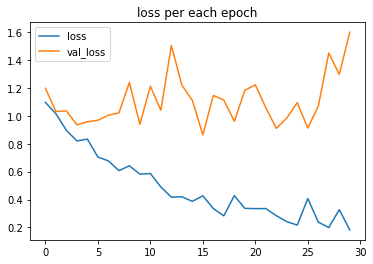

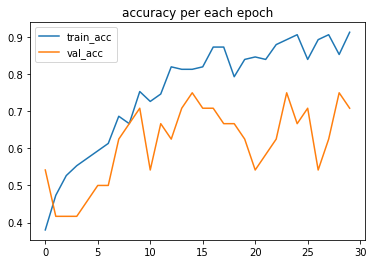

In [ ]:
metrics = LSTM_history.history
plt.plot(LSTM_history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss per each epoch')
plt.show()

plt.plot(LSTM_history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.title('accuracy per each epoch')
plt.legend(['train_acc','val_acc'])
plt.show()

In [ ]:
train_audio = []
train_labels = []

train_dss = preprocess_dataset(train_files)
for audio, label in train_dss:
  train_audio.append(audio.numpy())
  train_labels.append(label.numpy())

train_audio = np.array(train_audio)
train_labels = np.array(train_labels)

y_pred = np.argmax(LSTM.predict(train_ds), axis=1)
y_true = train_labels

train_acc = sum(y_pred == y_true) / len(y_true)
print(f'Train accuracy: {train_acc:.0%}')

Train accuracy: 89%


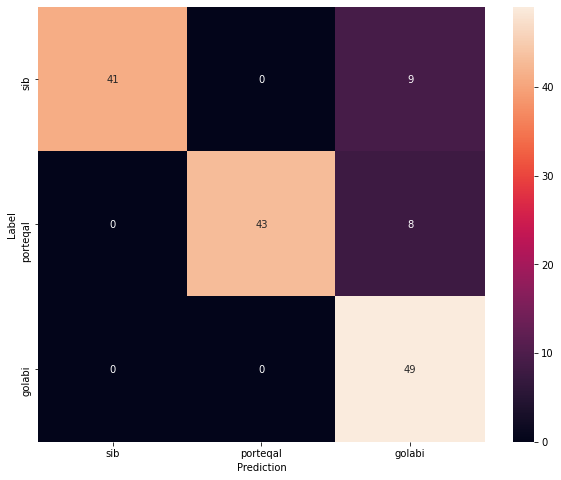

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
val_audio = []
val_labels = []

val_dss = preprocess_dataset(val_files)
for audio, label in val_dss:
  val_audio.append(audio.numpy())
  val_labels.append(label.numpy())

val_audio = np.array(val_audio)
val_labels = np.array(val_labels)

y_predv = np.argmax(LSTM.predict(val_ds), axis=1)
y_truev = val_labels

val_acc = sum(y_predv == y_truev) / len(y_truev)
print(f'Val accuracy: {val_acc:.0%}')

Val accuracy: 71%


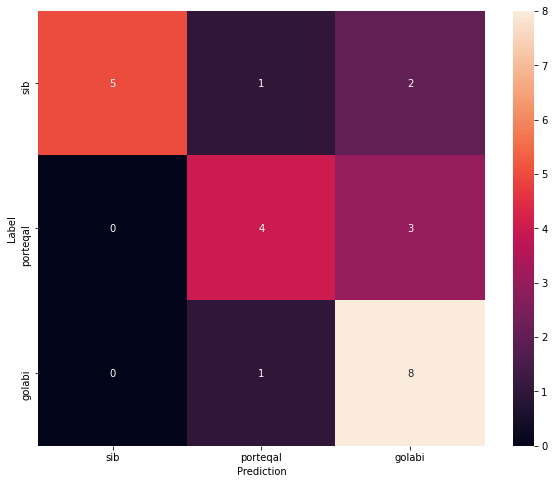

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_truev, y_predv) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
target_names=['Apple', 'Orange', 'Pear']
print(classification_report(y_truev, y_predv, target_names=target_names))

              precision    recall  f1-score   support

       Apple       1.00      0.62      0.77         8
      Orange       0.67      0.57      0.62         7
        Pear       0.62      0.89      0.73         9

    accuracy                           0.71        24
   macro avg       0.76      0.70      0.70        24
weighted avg       0.76      0.71      0.71        24



Test Function

In [ ]:
Test_path=glob.glob('/content/drive/MyDrive/DATA/TestData/*')

for i in range(len(Test_path)):
  sound = AudioSegment.from_mp3(Test_path[i])
  sound = sound.set_channels(1)
  sound.export("/content/drive/MyDrive/TestData_converted/test/t"+str(i+1)+".wav", format="wav")
  sound.export()

Test_dir = pathlib.Path('/content/drive/MyDrive/TestData_converted')
test_files = tf.io.gfile.glob(str(Test_dir) + '/*/*')
test_ds = preprocess_dataset(test_files)

AUTOTUNE = tf.data.AUTOTUNE
test_ds = test_ds.batch(1)
test_ds = test_ds.cache().prefetch(AUTOTUNE)
len(Test_path)

1

In [ ]:
def NormalizeData(data):
    Data = (data - np.min(data)) / (np.max(data) - np.min(data))*100
    return Data / np.sum(Data)

In [ ]:
y_MLP = NormalizeData(MLP.predict(test_ds))
y_CNN = NormalizeData(CNN.predict(test_ds))
y_LSTM = NormalizeData(LSTM.predict(test_ds))
methods = ['MLP', 'CNN', 'LSTM']
classes = ['Apple','Orange','Pear']
Table = np.matrix([y_MLP[0], y_CNN[0], y_LSTM[0]])
table = pd.DataFrame(Table, index=methods, columns=classes)

In [ ]:
print('probability predicted test data with 3 different model:\n ')
print(table)

probability predicted test data with 3 different model:
 
      Apple    Orange      Pear
MLP     0.0  0.012225  0.987775
CNN     0.0  0.000005  0.999995
LSTM    0.0  0.068350  0.931650
